First things first, load the data in.

In order to create the X vectors, we will need to go through each item in examples.json, and load the audio file into an array to create a list of 1D time series vectors. Pandas might have an easy way to do this already but I doubt it...

To get y we can just take the instrument_family column to get the encoded values.

In [1]:
import pandas as pd

train_data = pd.read_json("nsynth-train/examples.json", orient='index')
test_data = pd.read_json("nsynth-test/examples.json", orient='index')
valid_data = pd.read_json("nsynth-valid/examples.json", orient='index')

#Set the indices from the file name to sequential integers for easier indexing later.
#File name is kept in note_str anyway
train_data['index'] = range(1, len(train_data) + 1)
train_data = train_data.reset_index()

test_data['index'] = range(1,len(test_data) + 1)
test_data = test_data.reset_index()

valid_data['index'] = range(1,len(valid_data)+1)
valid_data = valid_data.reset_index()

test_data.head()

,level_0,qualities,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,instrument_family,instrument_family_str,index
0,bass_synthetic_068-049-025,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",49,217499,synthetic,25,bass_synthetic_068,656,16000,[dark],2,bass_synthetic_068-049-025,0,bass,1
1,keyboard_electronic_001-021-127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,299359,electronic,127,keyboard_electronic_001,40,16000,[],1,keyboard_electronic_001-021-127,4,keyboard,2
2,guitar_acoustic_010-066-100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",66,72288,acoustic,100,guitar_acoustic_010,219,16000,[],0,guitar_acoustic_010-066-100,3,guitar,3
3,reed_acoustic_037-068-127,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",68,22259,acoustic,127,reed_acoustic_037,387,16000,[reverb],0,reed_acoustic_037-068-127,7,reed,4
4,flute_acoustic_002-077-100,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",77,72001,acoustic,100,flute_acoustic_002,86,16000,[reverb],0,flute_acoustic_002-077-100,2,flute,5


In [2]:
train_data = train_data.loc[(train_data['instrument_source_str'] == 'acoustic') | (train_data['instrument_source_str'] == 'electronic')]
test_data = test_data.loc[(test_data['instrument_source_str'] == 'acoustic') | (test_data['instrument_source_str'] == 'electronic')]
valid_data = valid_data.loc[(valid_data['instrument_source_str'] == 'acoustic') | (valid_data['instrument_source_str'] == 'electronic')]

train_data.instrument_source_str.value_counts()

electronic    104434
acoustic      102165
Name: instrument_source_str, dtype: int64

Ok, we need to read in the audio files and convert them into spectrogram images. 

Define a function to take in the json file, and create the instrument_families as labels and spectrograms as data.
Using the tf.Dataset will be good because it's optimized to deal with large amounts of data instead of loading everthing into memory at once.

In [72]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def getTrainWav(label, instrument_family):
    file_location = "nsynth-train/audio/" + label + ".wav"
    audio_binary = tf.io.read_file(file_location)
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    waveform = tf.squeeze(audio)
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    equal_length = tf.expand_dims(equal_length,1)
    return equal_length, instrument_family

def getTestWav(label, instrument_family):
    file_location = "nsynth-test/audio/" + label + ".wav"
    audio_binary = tf.io.read_file(file_location)
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    waveform = tf.squeeze(audio)
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    equal_length = tf.expand_dims(equal_length,1)
    return equal_length, instrument_family

def getValidWav(label, instrument_family):
    file_location = "nsynth-valid/audio/" + label + ".wav"
    audio_binary = tf.io.read_file(file_location)
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    waveform = tf.squeeze(audio)
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    equal_length = tf.expand_dims(equal_length,1)
    return equal_length, instrument_family

def getSpectrogram(waveform, instrument_family):
    #zero pad to 64k samples, since each audio clip is 4 seconds sampled at 16kHz
    input_len = 64000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
      [64000] - tf.shape(waveform),
      dtype=tf.float32)

    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram, instrument_family
    
def trainPreProcess(train_data):
    train_ds = tf.data.Dataset.from_tensor_slices((train_data['note_str'].astype('string'), train_data['instrument_family']))
    train_ds = train_ds.map(map_func=getTrainWav, num_parallel_calls=tf.data.AUTOTUNE)
#     train_ds = train_ds.map(map_func=getSpectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    return train_ds

def testPreProcess(test_data):
    test_ds = tf.data.Dataset.from_tensor_slices((test_data['note_str'].astype('string'), test_data['instrument_family']))
    test_ds = test_ds.map(map_func=getTestWav, num_parallel_calls=tf.data.AUTOTUNE)
#     test_ds = test_ds.map(map_func=getSpectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    return test_ds

def validPreProcess(valid_data):
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_data['note_str'].astype('string'), valid_data['instrument_family']))
    valid_ds = valid_ds.map(map_func=getValidWav, num_parallel_calls=tf.data.AUTOTUNE)
#     valid_ds = valid_ds.map(map_func=getSpectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    return valid_ds
    
train_ds = trainPreProcess(train_data.loc[:50000,['instrument_family', 'note_str']])
test_ds = testPreProcess(test_data.loc[:,['instrument_family', 'note_str']])
valid_ds = validPreProcess(valid_data.loc[:,['instrument_family', 'note_str']])

batch_size = 64
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
valid_ds = valid_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(tf.data.AUTOTUNE)


In [62]:
for waveform, label in train_ds.take(1):
    print(waveform)
    print(label)
    
print(train_ds)

tf.Tensor(
[[[ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]

 [[ 4.8797607e-02]
  [ 3.6602783e-01]
  [ 3.8562012e-01]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]

 [[ 6.1035156e-05]
  [-9.1552734e-05]
  [ 1.2207031e-04]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]

 ...

 [[ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]

 [[ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]

 [[ 0.0000000e+00]
  [-9.1552734e-05]
  [ 2.1362305e-04]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]], shape=(64, 64000, 1), dtype=float32)
tf.Tensor(
[ 3  0  6  3  6  4  0  4  4  4 10 10  6  4  3  6  4  8  0  7  2  5  0  3
  0  0  8  8  4  7  0  0  4  0  0  5  1  4  0  0  6  3  3  0  4  4  2  0
  4  6  0  4  4  0  4  6  1  4  4  0  0  6  8  4], shape

We want to build a keras model. It should be pretty straightforward if we just look at the example from tensorflow.


In [73]:
from tensorflow.keras import layers
from tensorflow.keras import models

for spectrogram, _ in train_ds.take(1):
    input_shape = spectrogram[0].shape

print('Input shape:', input_shape)
num_labels = 11

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
# norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
#     layers.Resizing(64,64),
    # Normalize.
#     norm_layer,
    layers.Conv1D(64, 7, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(32, 5, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(16, 3, activation='relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Input shape: (16000, 1)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 15994, 64)         512       
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 7997, 64)         0         
 g1D)                                                            
                                                                 
 conv1d_33 (Conv1D)          (None, 7993, 32)          10272     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 3996, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_34 (Conv1D)          (None, 3994, 16)          1552      
                                                                 
 max_pooling1d_16 (MaxPoolin 

Now we call fit and train the damn thing. 

In [74]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS
)

Epoch 1/10
782/782 [==============================] - 1211s 2s/step - loss: 1.5554 - accuracy: 0.4360 - val_loss: 1.5712 - val_accuracy: 0.4617
Epoch 2/10
782/782 [==============================] - 1059s 1s/step - loss: 1.1938 - accuracy: 0.5749 - val_loss: 1.7649 - val_accuracy: 0.4684
Epoch 3/10
782/782 [==============================] - 1028s 1s/step - loss: 0.9351 - accuracy: 0.6701 - val_loss: 1.9157 - val_accuracy: 0.4814
Epoch 4/10
782/782 [==============================] - 987s 1s/step - loss: 0.7327 - accuracy: 0.7408 - val_loss: 2.0515 - val_accuracy: 0.4839
Epoch 5/10
782/782 [==============================] - 999s 1s/step - loss: 0.5854 - accuracy: 0.7933 - val_loss: 2.2432 - val_accuracy: 0.4802
Epoch 6/10
782/782 [==============================] - 970s 1s/step - loss: 0.4870 - accuracy: 0.8267 - val_loss: 2.5957 - val_accuracy: 0.4731
Epoch 7/10
782/782 [==============================] - 968s 1s/step - loss: 0.4102 - accuracy: 0.8526 - val_loss: 2.6558 - val_accuracy: 0.5

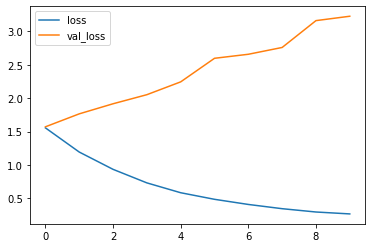

In [75]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [90]:
y_pred = np.argmax(model.predict(test_ds),axis=1)
y_true = test_data['instrument_family']

In [77]:
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 51%


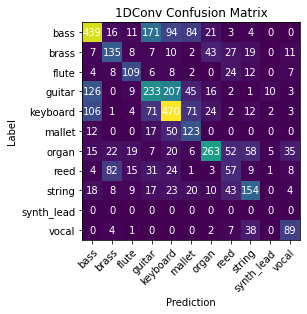

In [111]:
instrument_families = ['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'synth_lead', 'vocal']

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots()


ax.matshow(confusion_mtx)
ax.set_xticks(np.arange(len(instrument_families)), labels=instrument_families)
ax.set_yticks(np.arange(len(instrument_families)), labels=instrument_families)

for i in range(11):
    for j in range(11):
        text = ax.text(j, i, confusion_mtx.numpy()[i, j],
                       ha="center", va="center", color="w")

ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.xlabel('Prediction')
plt.ylabel('Label')

ax.set_title("1DConv Confusion Matrix")
plt.show()